### Pre-process step 1
- This pre processing step first rotates the full frame to flatten the spectrum using rotationsl transformation
- Following rotation, the image is affine transformed to straighten the skew in the slit due to the prism
- Needs: Calibration sequence
    - Acquire calibration sequence after any modifications to the system or at the start of every month if no modifications are made
    - Turn on all lasers and acquire a short sequence at full frame


In [1]:
import pandas as pd
import numpy as np
import os
import glob
from config import load_config
paths = load_config(dataset_key='all')
from natsort import natsorted
from skimage import io
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import cv2 as cv
from PIL import Image


Paths are for dataset tagged: all


In [2]:
# Load calibration sequence images and metadata
path = paths['calibration_data']
metadata_file = glob.glob(os.path.join(path,'*.csv'))
print(metadata_file)
metadata = pd.read_csv(metadata_file[0])
files = os.listdir(path)
print(files)
tiff_dir = os.path.join(path,files[3])
tiff_files = os.listdir(tiff_dir)
tiff_files = np.array(natsorted(tiff_files))
print(tiff_files)
tiff_file_path = os.path.join(tiff_dir,tiff_files[0])
tiff = Image.open(tiff_file_path)
image_sequence = []
while True:
    try:
        image_sequence.append(np.array(tiff))
        tiff.seek(tiff.tell() + 1)
    except EOFError:
        break


['C:\\AIND\\output_data\\Tiffs_2024-08-13T11_05_11.4966912-07_00\\sessionproperties_2024-08-13T11_05_11.csv', 'C:\\AIND\\output_data\\Tiffs_2024-08-13T11_05_11.4966912-07_00\\TTL_TS2024-08-13T11_05_11.csv']
['hsfp_rig.json', 'ophys_session.json', 'sessionproperties_2024-08-13T11_05_11.csv', 'Tiffs', 'TTL_2024-08-13T11_05_11.4978176-07_00', 'TTL_TS2024-08-13T11_05_11.csv']
['Tiffs0.tif' 'Tiffs1.tif' 'Tiffs48.tif' 'Tiffs49.tif' 'Tiffs50.tif'
 'Tiffs51.tif']


ValueError: buffer is not large enough

(228, 2012)
2012
20
228
552


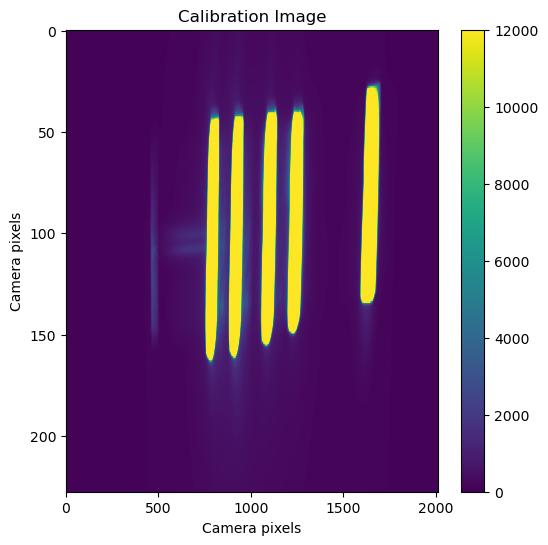

In [3]:
# Average all frames 
img = np.array(image_sequence)
img2d = img.mean(axis=0)
print(img2d.shape)
width = metadata.Width[0]
print(width)
Xoffset = metadata.Left[0]
print(Xoffset)
height = metadata.Height[0]
print(height)
Yoffset = metadata.Top[0]
print(Yoffset)
img_to_unskew = np.array(img2d)
f,ax = plt.subplots(figsize=(6,6))
i = ax.imshow(img_to_unskew, aspect='auto', vmin=0, vmax=12000)
ax.set(xlabel='Camera pixels', ylabel='Camera pixels', title='Calibration Image')
ax.grid(False)
f.colorbar(i,ax=ax)
plt.show()

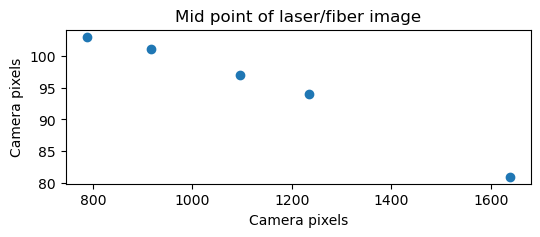

-1.1534504511053671


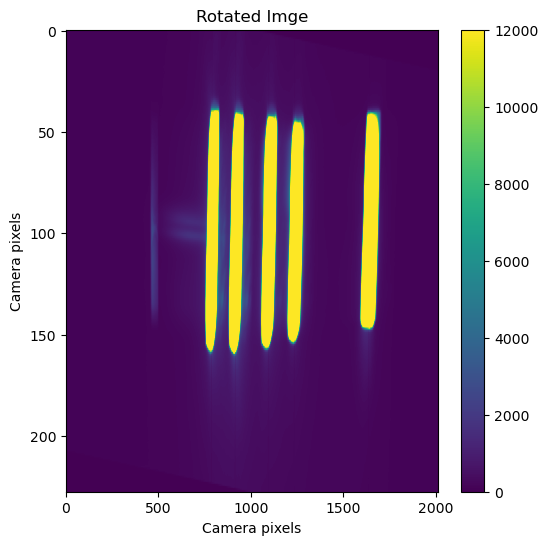

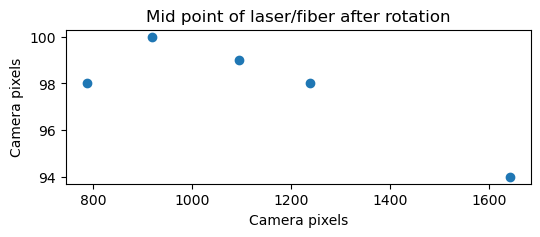

[ 788  919 1095 1238 1641]
[ 98 100  99  98  94]


In [4]:
# Extract rotation of image to flatten spectrum
h_line = np.mean(img_to_unskew,axis=0)
h_laser_pix, _ = find_peaks(h_line, height=2000, distance=100)
count = 0
sat_val = 12000
v_laser_pix = np.zeros(np.size(h_laser_pix))
for l in h_laser_pix:
    v_line = img_to_unskew[:,l]
    v_line[v_line<sat_val] = 0
    idx = np.nonzero(np.diff(v_line))[0]
    v_laser_pix[count] = np.round((idx[0]+idx[-1])/2)
    count +=1

f, ax = plt.subplots(figsize=(6,2))
ax.plot(h_laser_pix,v_laser_pix,'o')
ax.set(xlabel='Camera pixels', ylabel='Camera pixels', title='Mid point of laser/fiber image')
plt.show()

# Angle to rotate
theta_r = np.rad2deg(np.arctan((v_laser_pix[-2]-v_laser_pix[0])/(h_laser_pix[-2]-h_laser_pix[0])))
print(theta_r)

# Rotation using openCV
rows,cols = img_to_unskew.shape
M = cv.getRotationMatrix2D(((cols-1)/2.0,(rows-1)/2.0),theta_r,1)
img_rotated = cv.warpAffine(img_to_unskew,M,(cols,rows))
img_rotated.shape
f,ax = plt.subplots(figsize=(6,6))
i = ax.imshow(img_rotated, aspect='auto', vmin=0, vmax=12000)
ax.set(xlabel='Camera pixels', ylabel='Camera pixels', title='Rotated Imge')
ax.grid(False)
f.colorbar(i,ax=ax)
plt.show()

# Check position of lasers in rotated image
h_line = np.mean(img_rotated,axis=0)
h_laser_pix, _ = find_peaks(h_line, height=2000, distance=100)
count = 0
v_laser_pix = np.zeros(np.size(h_laser_pix))
for l in h_laser_pix:
    v_line = img_rotated[:,l]
    v_line[v_line<sat_val] = 0
    idx = np.nonzero(np.diff(v_line))[0]
    v_laser_pix[count] = np.round((idx[0]+idx[-1])/2)
    count +=1
v_laser_pix = v_laser_pix.astype(int)
f, ax = plt.subplots(figsize=(6,2))
ax.plot(h_laser_pix,v_laser_pix,'o')
ax.set(xlabel='Camera pixels', ylabel='Camera pixels', title='Mid point of laser/fiber after rotation')
plt.show()
print(h_laser_pix)
print(v_laser_pix)


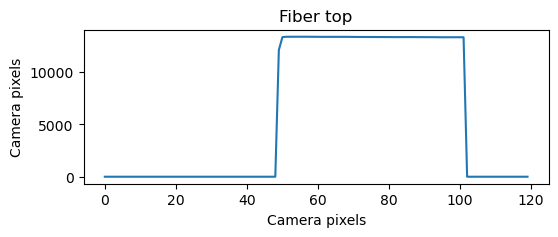

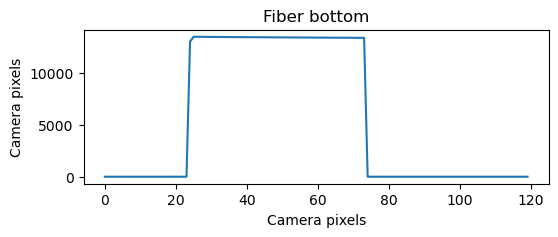

[41, 158]
[907, 882]


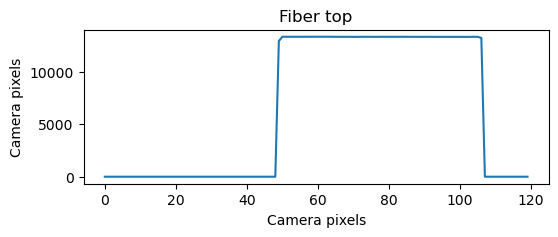

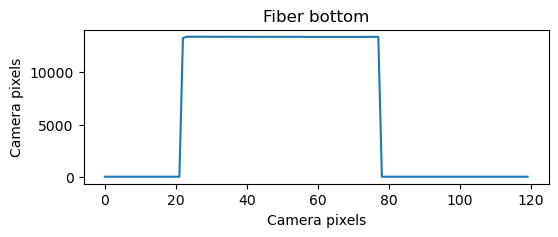

[43, 155]
[1083, 1056]


In [5]:
# Extract rotation of slit to straighten the spectrum
use_laser = 1

# Calculate the y-coordinates
v_line = img_rotated[:,h_laser_pix[use_laser]]
v_line[v_line<sat_val] = 0
idx = np.nonzero(np.diff(v_line))[0]
v_width = [idx[0],idx[-1]]

fiber_width = 60

# Calculate the x-coordinates
h_line_top = img_rotated[v_width[0]+5,h_laser_pix[use_laser]-fiber_width:h_laser_pix[use_laser]+fiber_width]
h_line_top[h_line_top<sat_val] = 0
h_line_top_width = np.nonzero(np.diff(h_line_top))[0]
h_top = h_line_top_width[0]
f, ax = plt.subplots(figsize=(6,2))
ax.plot(h_line_top)
ax.set(xlabel='Camera pixels', ylabel='Camera pixels', title='Fiber top')
plt.show()

h_line_bot = img_rotated[v_width[1]-5,h_laser_pix[use_laser]-fiber_width:h_laser_pix[use_laser]+fiber_width]
h_line_bot[h_line_bot<sat_val] = 0
h_line_bot_width = np.nonzero(np.diff(h_line_bot))[0]
h_bot = h_line_bot_width[0]
f, ax = plt.subplots(figsize=(6,2))
ax.plot(h_line_bot)
ax.set(xlabel='Camera pixels', ylabel='Camera pixels', title='Fiber bottom')
plt.show()
h_width = [h_laser_pix[use_laser]-fiber_width+h_top, h_laser_pix[use_laser]-fiber_width+h_bot]

print(v_width)
print(h_width)

use_laser = 2
# Calculate the y-coordinates
v_line = img_rotated[:,h_laser_pix[use_laser]]
v_line[v_line<sat_val] = 0
idx = np.nonzero(np.diff(v_line))[0]
v_width2 = [idx[0],idx[-1]]

# Calculate the x-coordinates
h_line_top = img_rotated[v_width2[0]+5,h_laser_pix[use_laser]-fiber_width:h_laser_pix[use_laser]+fiber_width]
h_line_top[h_line_top<sat_val] = 0
h_line_top_width = np.nonzero(np.diff(h_line_top))[0]
h_top = h_line_top_width[0]
f, ax = plt.subplots(figsize=(6,2))
ax.plot(h_line_top)
ax.set(xlabel='Camera pixels', ylabel='Camera pixels', title='Fiber top')
plt.show()

h_line_bot = img_rotated[v_width2[1]-5,h_laser_pix[use_laser]-fiber_width:h_laser_pix[use_laser]+fiber_width]
h_line_bot[h_line_bot<sat_val] = 0
h_line_bot_width = np.nonzero(np.diff(h_line_bot))[0]
h_bot = h_line_bot_width[0]
f, ax = plt.subplots(figsize=(6,2))
ax.plot(h_line_bot)
ax.set(xlabel='Camera pixels', ylabel='Camera pixels', title='Fiber bottom')
plt.show()
h_width2 = [h_laser_pix[use_laser]-fiber_width+h_top, h_laser_pix[use_laser]-fiber_width+h_bot]

print(v_width2)
print(h_width2)

[907, 41] [882, 158] [1083, 43] [882, 41] [882, 158] [1056, 43]


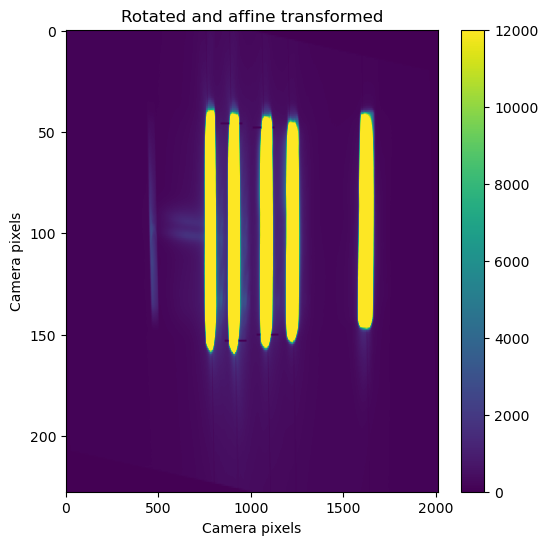

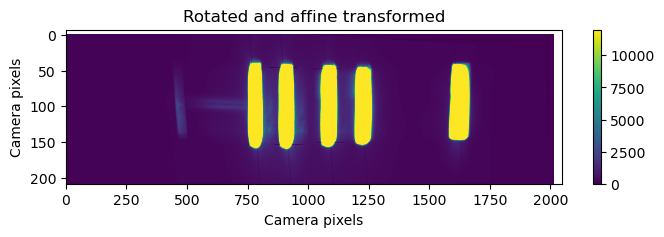

In [6]:
# Affine transformation
pt1 = [h_width[0], v_width[0]]
pt2 = [h_width[1], v_width[1]]
pt3 = [h_width2[0], v_width2[0]]
pt4 = [h_width[1], v_width[0]]
pt5 = [h_width[1], v_width[1]]
pt6 = [h_width2[1], v_width2[0]]
print(pt1, pt2, pt3, pt4, pt5, pt6)

rows,cols = img_rotated.shape
pts1 = np.float32([pt1, pt2, pt3])
pts2 = np.float32([pt4, pt5, pt6])
M = cv.getAffineTransform(pts1,pts2)
img_final = cv.warpAffine(img_rotated,M,(cols,rows))

f,ax = plt.subplots(figsize=(6,6))
i = ax.imshow(img_final, aspect='auto', vmin=0, vmax=12000)
ax.set(xlabel='Camera pixels', ylabel='Camera pixels', title='Rotated and affine transformed')
ax.grid(False)
f.colorbar(i,ax=ax)
plt.show()

f,ax = plt.subplots(figsize=(8,2))
i = ax.imshow(img_final, aspect='auto', vmin=0, vmax=12000)
ax.set(xlabel='Camera pixels', ylabel='Camera pixels',  title='Rotated and affine transformed', xlim=[0,2048], ylim=[pt5[1]+50,pt6[1]-50])
ax.grid(False)
f.colorbar(i,ax=ax)
plt.show()


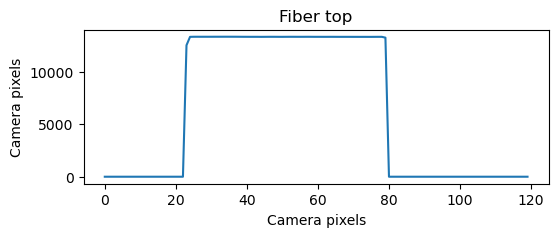

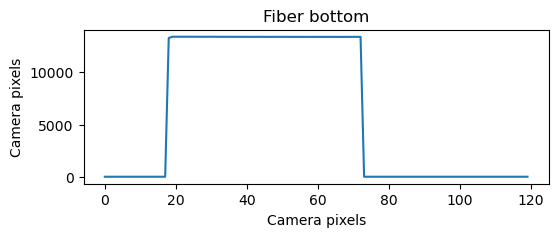

In [7]:
# Check laser top and bottom after affine transformation
use_laser = 2
# Calculate the y-coordinates
v_line = img_final[:,h_laser_pix[use_laser]]
v_line[v_line<sat_val] = 0
idx = np.nonzero(np.diff(v_line))[0]
v_width = [idx[0],idx[-1]]
# Calculate the x-coordinates
h_line_top = img_final[v_width[0]+5,h_laser_pix[use_laser]-fiber_width:h_laser_pix[use_laser]+fiber_width]
h_line_top[h_line_top<sat_val] = 0
h_line_top_width = np.nonzero(np.diff(h_line_top))[0]
h_top = h_line_top_width[0]
f, ax = plt.subplots(figsize=(6,2))
ax.plot(h_line_top)
ax.set(xlabel='Camera pixels', ylabel='Camera pixels', title='Fiber top')
plt.show()
h_line_bot = img_final[v_width[1]-5,h_laser_pix[use_laser]-fiber_width:h_laser_pix[use_laser]+fiber_width]
h_line_bot[h_line_bot<sat_val] = 0
h_line_bot_width = np.nonzero(np.diff(h_line_bot))[0]
h_bot = h_line_bot_width[0]
f, ax = plt.subplots(figsize=(6,2))
ax.plot(h_line_bot)
ax.set(xlabel='Camera pixels', ylabel='Camera pixels', title='Fiber bottom')
plt.show()

[42, 156]
[42, 92] [106, 156]


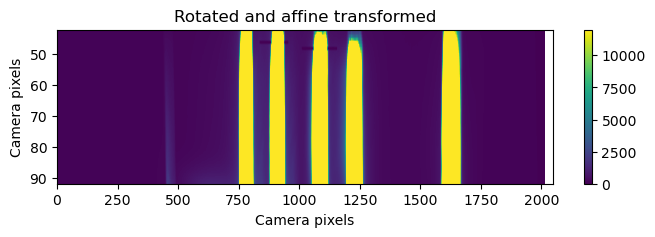

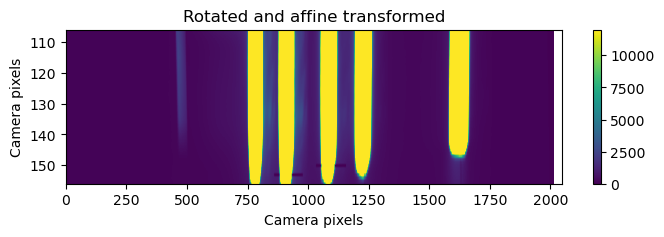

In [8]:
# Find pixels that correspond to fiber1 and fiber2
use_laser = 2
h_line_new = np.mean(img_final,axis=0)
h_laser_pix_new, _ = find_peaks(h_line_new, height=2000, distance=100)
v_line = img_final[:,h_laser_pix_new[use_laser]]
v_line[v_line<sat_val] = 0
idx = np.nonzero(np.diff(v_line))[0]
v_width = [idx[0],idx[-1]]
print(v_width)

fiber1_top = v_width[0]
fiber1_bottom = v_width[0]+50
fiber2_top = v_width[1]-50
fiber2_bottom = v_width[1]

fiber1 = [fiber1_top, fiber1_bottom]
fiber2 = [fiber2_top, fiber2_bottom]
print(fiber1, fiber2)

# Fiber1 location
f,ax = plt.subplots(figsize=(8,2))
i = ax.imshow(img_final, aspect='auto', vmin=0, vmax=12000)
ax.set(xlabel='Camera pixels', ylabel='Camera pixels',  title='Rotated and affine transformed', xlim=[0,2048], ylim=[fiber1[1],fiber1[0]])
ax.grid(False)
f.colorbar(i,ax=ax)
plt.show()

# Fiber2 location
f,ax = plt.subplots(figsize=(8,2))
i = ax.imshow(img_final, aspect='auto', vmin=0, vmax=12000)
ax.set(xlabel='Camera pixels', ylabel='Camera pixels',  title='Rotated and affine transformed', xlim=[0,2048], ylim=[fiber2[1],fiber2[0]])
ax.grid(False)
f.colorbar(i,ax=ax)
plt.show()

In [9]:
pt1[0] = pt1[0] + Xoffset
pt2[0] = pt2[0] + Xoffset
pt3[0] = pt3[0] + Xoffset
pt4[0] = pt4[0] + Xoffset
pt5[0] = pt5[0] + Xoffset
pt6[0] = pt6[0] + Xoffset
pt1[1] = pt1[1] + Yoffset
pt2[1] = pt2[1] + Yoffset
pt3[1] = pt3[1] + Yoffset
pt4[1] = pt4[1] + Yoffset
pt5[1] = pt5[1] + Yoffset
pt6[1] = pt6[1] + Yoffset

fiber1[0] = fiber1[0] + Yoffset
fiber1[1] = fiber1[1] + Yoffset
fiber2[0] = fiber2[0] + Yoffset
fiber2[1] = fiber2[1] + Yoffset

print(pt1, pt2, pt3, pt4, pt5, pt6, fiber1, fiber2)


[927, 593] [902, 710] [1103, 595] [902, 593] [902, 710] [1076, 595] [594, 644] [658, 708]


In [10]:
# Save transformed image for wavelength calibration
img_final = img_final.astype(int)
path = paths['raw_data']
output_file = f"{path}/CalibrationImage.tiff"
cv.imwrite(output_file, img_final)

with open(paths['raw_data'] / 'calibration.txt','w') as f:
    f.write(f'rot_tform_thetaR = {theta_r}\n')
    f.write(f'aff_tform_pt1 = {pt1}\n')
    f.write(f'aff_tform_pt2 = {pt2}\n')
    f.write(f'aff_tform_pt3 = {pt3}\n')
    f.write(f'aff_tform_pt4 = {pt4}\n')
    f.write(f'aff_tform_pt5 = {pt5}\n')
    f.write(f'aff_tform_pt6 = {pt6}\n')
    f.write(f'fiber1_pixels = {fiber1}\n')
    f.write(f'fiber2_pixels = {fiber2}\n')
    f.write(f'calib_Xoffset = {Xoffset}\n')
